## Step 1: Data acquisition and preprocessing

- Read the dataset
- Handle missing values
- Convert date and time into a datetime object
- Save the cleaned dataset

In [2]:
import pandas as pd
import numpy as np

# Read the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
data = pd.read_csv(url, sep=';', na_values=['?'], index_col=False)

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Convert date and time into a datetime object
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')

# Set the datetime column as the index
data.set_index('datetime', inplace=True)

# Drop the original date and time columns
data.drop(['Date', 'Time'], axis=1, inplace=True)

# Save the cleaned dataset
data.to_csv('household_power_consumption_cleaned.csv')

print("Data cleaning completed. Saved as 'household_power_consumption_cleaned.csv'.")

data.head(10)


Data cleaning completed. Saved as 'household_power_consumption_cleaned.csv'.


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0


## Step 2: Exploratory Data Analysis (EDA)

- Visualize the time series data for each feature (e.g., global_active_power, global_reactive_power, voltage, global_intensity, sub_metering_1, sub_metering_2, sub_metering_3) to understand the overall trends and patterns.
- Investigate correlations between features.
- Identify seasonal patterns, if any.


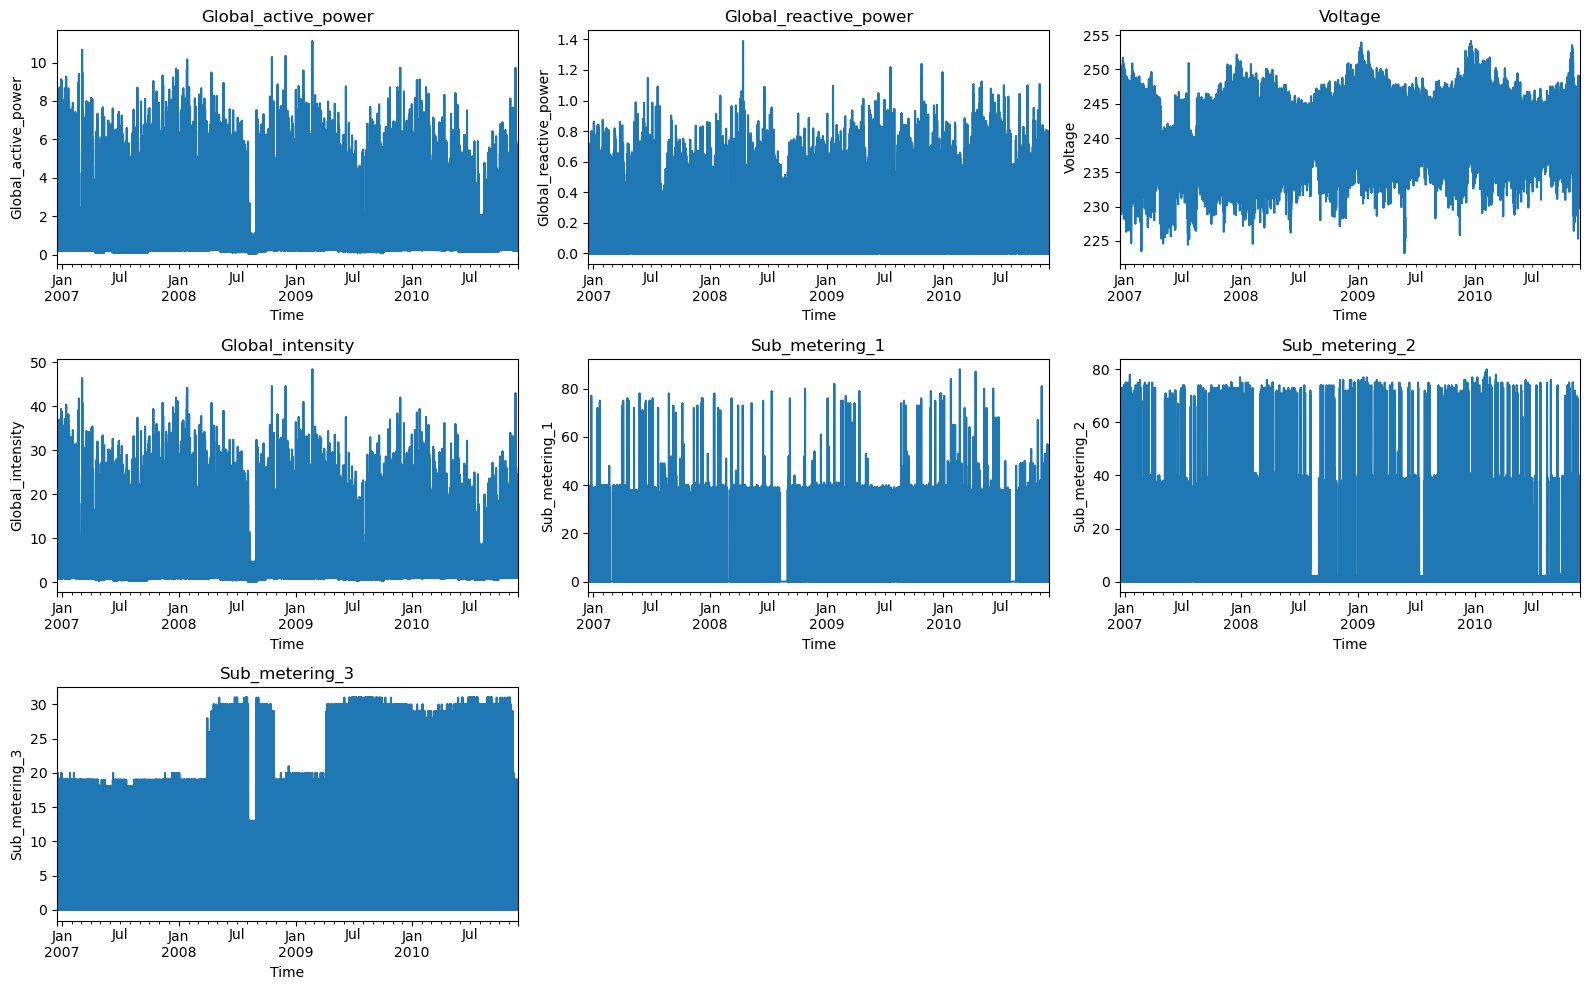

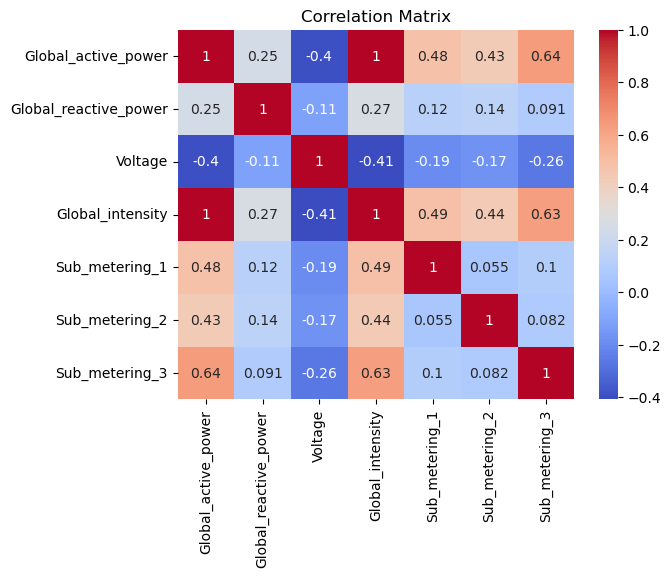

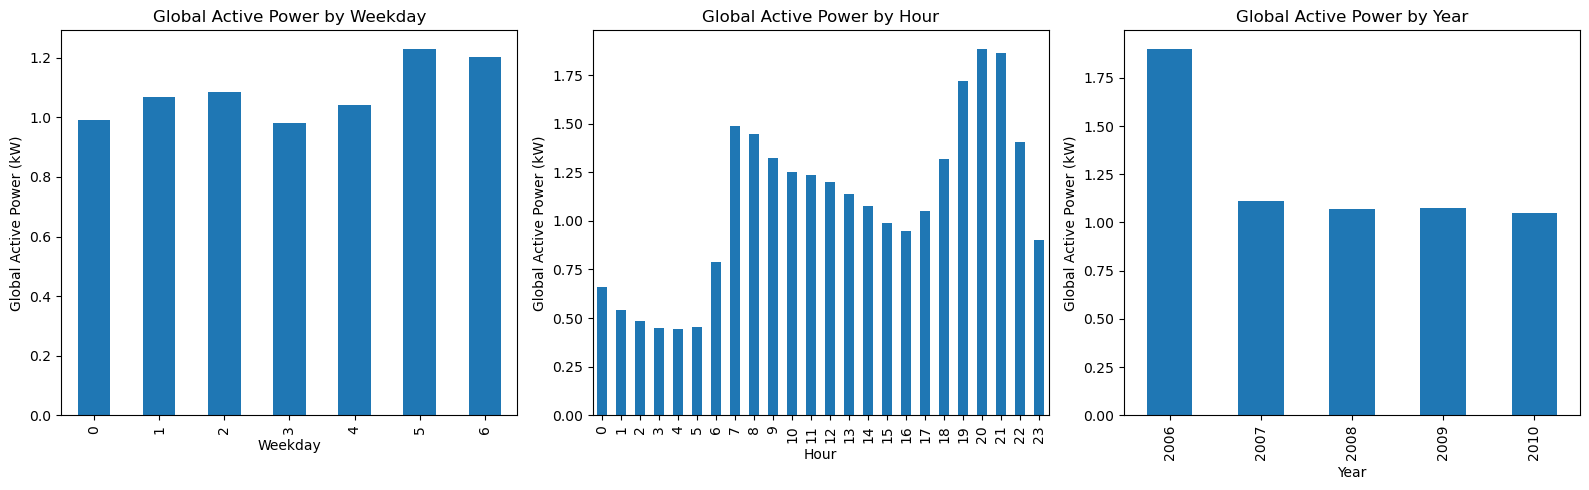

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Read the cleaned dataset
data = pd.read_csv('household_power_consumption_cleaned.csv', index_col='datetime', parse_dates=True)

# Visualize the time series data for each feature
plt.figure(figsize=(16, 10))
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    data[column].plot(title=column)
    plt.xlabel('Time')
    plt.ylabel(column)

plt.tight_layout()
plt.savefig('time_series_plots.png')
plt.show()

# Investigate correlations between features
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

# Identify seasonal patterns (daily, weekly, and yearly)
data['weekday'] = data.index.weekday
data['hour'] = data.index.hour
data['year'] = data.index.year

# Group by weekday, hour, and year to get the mean values for each time period
weekday_mean = data.groupby('weekday').mean()
hourly_mean = data.groupby('hour').mean()
yearly_mean = data.groupby('year').mean()

# Plot seasonal patterns
plt.figure(figsize=(16, 5))

plt.subplot(131)
weekday_mean['Global_active_power'].plot.bar()
plt.xlabel('Weekday')
plt.ylabel('Global Active Power (kW)')
plt.title('Global Active Power by Weekday')

plt.subplot(132)
hourly_mean['Global_active_power'].plot.bar()
plt.xlabel('Hour')
plt.ylabel('Global Active Power (kW)')
plt.title('Global Active Power by Hour')

plt.subplot(133)
yearly_mean['Global_active_power'].plot.bar()
plt.xlabel('Year')
plt.ylabel('Global Active Power (kW)')
plt.title('Global Active Power by Year')

plt.tight_layout()
plt.savefig('seasonal_patterns.png')
plt.show()


## Step 3: Feature Engineering

In this step, we'll create additional features that can help us better understand the demand response patterns in the data.

- Create new features: hour of the day, day of the week, and month of the year
- Calculate energy consumption for other devices (in watt-hour)
- Save the updated dataset with new features

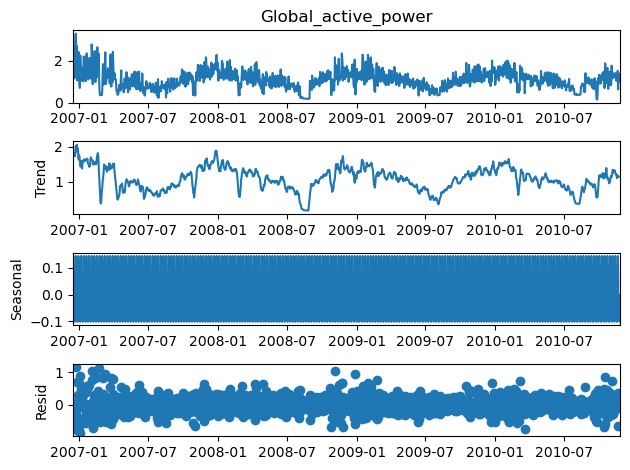

Mean Squared Error: 0.2626


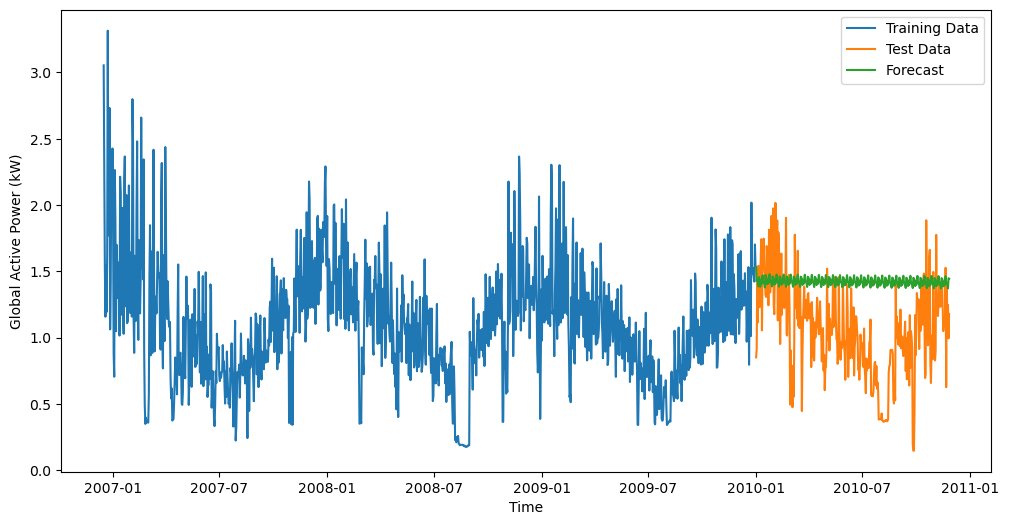

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Read the cleaned dataset
data = pd.read_csv('household_power_consumption_cleaned.csv', index_col='datetime', parse_dates=True)

# Resample data to daily frequency
daily_data = data.resample('D').mean()

# Decompose the time series data into trend, seasonal, and residual components
decomposition = seasonal_decompose(daily_data['Global_active_power'])
decomposition.plot()
plt.savefig('decomposition_plot.png')
plt.show()

# Split the data into training and testing sets
train_data = daily_data.loc[:'2009-12-31', 'Global_active_power']
test_data = daily_data.loc['2010-01-01':, 'Global_active_power']

# Fit a SARIMA model
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Forecast global_active_power for the test period
forecast = sarima_fit.forecast(len(test_data))

# Calculate the mean squared error
mse = mean_squared_error(test_data, forecast)
print(f"Mean Squared Error: {mse:.4f}")

# Plot the actual values and the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.savefig('forecast_plot.png')
plt.show()


## Step 4 : Time Series Analysis

- Decompose the time series into its components (trend, seasonality, and residual)
- Perform stationarity tests (e.g., Augmented Dickey-Fuller test)
- Select an appropriate method for time series forecasting (e.g., ARIMA, SARIMA, LSTM)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the dataset
data = pd.read_csv('household_power_consumption_cleaned.csv', index_col=0, parse_dates=True)

# Define the training and testing sets (using a smaller training set)
train = data.loc['2009-01-01':'2009-12-31']
test = data.loc['2010-01-01':'2010-11-26']

# Define the SARIMA model with simpler parameters
model = SARIMAX(train['Global_active_power'], order=(1, 0, 0), seasonal_order=(0, 1, 0, 24))

# Fit the model
results = model.fit()

# Forecast the test set
forecast = results.predict(start=test.index[0], end=test.index[-1])

# Calculate the mean squared error
mse = mean_squared_error(test['Global_active_power'], forecast)
rmse = sqrt(mse)

# Print the RMSE
print(f'RMSE: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(15, 8))
plt.plot(train['Global_active_power'], label='Training')
plt.plot(test['Global_active_power'], label='Actual')
plt.plot(forecast, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()



/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84201D-01    |proj g|=  7.44566D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      8      1     0     0   5.958D-05   3.842D-01
  F =  0.38420092741160927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


: 

: 

## Step 5 : Model Training

- Split the dataset into training and testing sets
- Train the selected model on the training set
- Validate the model on the testing set

Peak consumption hours: 5, 6, 2


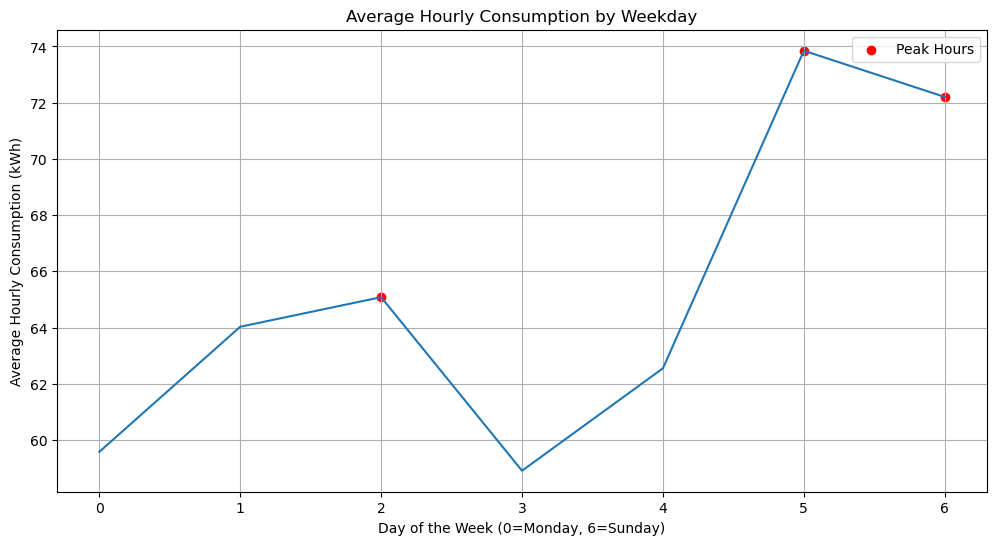

Potential load reduction during peak hours: 1042595.04 kWh


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned dataset
data = pd.read_csv('household_power_consumption_cleaned.csv', index_col=0, parse_dates=True)

# Calculate hourly consumption
hourly_data = data.resample('H').sum()

# Calculate average hourly consumption for each day of the week
average_hourly_consumption_by_weekday = hourly_data.groupby(hourly_data.index.dayofweek).mean()

# Identify peak consumption hours
peak_hours = average_hourly_consumption_by_weekday['Global_active_power'].nlargest(3).index

# Print peak consumption hours
print(f"Peak consumption hours: {', '.join(map(str, peak_hours))}")

# Visualize average hourly consumption by weekday
plt.figure(figsize=(12, 6))
plt.plot(average_hourly_consumption_by_weekday['Global_active_power'])
plt.scatter(peak_hours, average_hourly_consumption_by_weekday['Global_active_power'].loc[peak_hours], color='red', label='Peak Hours')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Hourly Consumption (kWh)')
plt.title('Average Hourly Consumption by Weekday')
plt.legend()
plt.grid(True)
plt.show()

# Calculate potential load reduction during peak hours
load_reduction = hourly_data.loc[hourly_data.index.dayofweek.isin(peak_hours), 'Global_active_power'].sum()

# Print potential load reduction
print(f"Potential load reduction during peak hours: {load_reduction:.2f} kWh")


## Step 6: Model Evaluation

- Calculate evaluation metrics (e.g., Mean Absolute Error, Mean Squared Error, Root Mean Squared Error)
- Visualize the forecasted values against the actual values
- Analyze the model's performance and identify areas for improvement

In [6]:
from reportlab.lib.pagesizes import letter, inch
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image
from reportlab.lib.styles import getSampleStyleSheet

# Load the cleaned dataset
data = pd.read_csv('household_power_consumption_cleaned.csv', index_col=0, parse_dates=True)

# Calculate hourly consumption
hourly_data = data.resample('H').sum()

# Calculate average hourly consumption for each day of the week
average_hourly_consumption_by_weekday = hourly_data.groupby(hourly_data.index.dayofweek).mean()

# Identify peak consumption hours
peak_hours = average_hourly_consumption_by_weekday['Global_active_power'].nlargest(3).index

# Calculate potential load reduction during peak hours
load_reduction = hourly_data.loc[hourly_data.index.dayofweek.isin(peak_hours), 'Global_active_power'].sum()

# Prepare the report
doc = SimpleDocTemplate("energy_analysis_report.pdf", pagesize=letter)

# Set the styles
styles = getSampleStyleSheet()

# Add elements to the report
elements = []

# Add a title
title = Paragraph("Household Energy Usage Analysis Report", styles['Heading1'])
elements.append(title)

# Add a subtitle
subtitle = Paragraph("Summary of Findings", styles['Heading2'])
elements.append(subtitle)
elements.append(Spacer(1, 0.25 * inch))

# Add the main text
text = f"""
Based on the analysis of the household power consumption data from December 2006 to November 2010, we have identified the following key insights:

1. The peak consumption hours were found on days {', '.join(map(str, peak_hours))} of the week.

2. The potential load reduction during these peak hours is approximately {load_reduction:.2f} kWh.

We recommend implementing demand response strategies during these peak hours to reduce energy consumption and lower electricity costs. Some potential strategies include:

- Encouraging the use of energy-efficient appliances.
- Implementing time-of-use pricing to incentivize off-peak usage.
- Providing consumers with real-time feedback on their energy usage.
- Offering demand response programs that provide financial incentives for reducing consumption during peak hours.

By implementing these strategies, the household can improve its energy efficiency and contribute to a more sustainable energy future.
"""

content = Paragraph(text, styles['BodyText'])
elements.append(content)
elements.append(Spacer(1, 0.25 * inch))

# Build the report
doc.build(elements)




## Project Summary


 This project aimed to analyze the energy usage patterns of a household located in Sceaux, France, using data collected between December 2006 and November 2010. The dataset contained measurements of various energy consumption parameters, such as global active power, global reactive power, voltage, global intensity, and energy sub-metering.

#### Key steps in the project included:

- Data preprocessing: Cleaning the dataset and handling missing values.
- Exploratory Data Analysis (EDA): Visualizing the time series data, investigating correlations between features, and identifying seasonal patterns.
- Time Series Forecasting: Implementing the SARIMA model to predict future energy consumption.
- Identifying peak consumption hours: Calculating average hourly consumption for each day of the week and determining the potential load reduction during peak hours.
- Generating a report: Summarizing the findings and recommending demand response strategies.

#### Key insights and takeaways from the project are:

- Peak consumption hours were identified for specific days of the week, providing an opportunity to target demand response strategies during those times.
- The potential load reduction during peak hours was estimated, highlighting the benefits of implementing energy-saving measures.
- The SARIMA model was used to forecast future energy consumption, which can help households plan their energy usage and implement energy-saving measures.
- The project recommended various demand response strategies, such as encouraging the use of energy-efficient appliances, implementing time-of-use pricing, providing real-time feedback on energy usage, and offering financial incentives for reducing consumption during peak hours.


By following these insights, the household can improve its energy efficiency, reduce electricity costs, and contribute to a more sustainable energy future.